# Mask R-CNN - Train on Cityscape Dataset

In [1]:
import os
import sys
import random
import time
import numpy as np
import skimage
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib

%matplotlib inline 

os.environ["CUDA_VISIBLE_DEVICES"] = '3'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


KeyboardInterrupt: 

## Configurations

In [10]:
class CityscapeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscapes"
    
    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 8 class

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    #BACKBONE_STRIDES = [8, 16, 32, 64]
    
    # Length of square anchor side in pixels
    #RPN_ANCHOR_SCALES = (64, 128, 256, 512)
    
    # Image mean (RGB)
    MEAN_PIXEL = np.array([122.67891434,116.66876762,104.00698793])
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (128, 128)  # (height, width) of the mini-mask
    
    #DETECTION_MIN_CONFIDENCE = 0.5
    FLOW = None
    BACKBONE = "resnet50"
config = CityscapeConfig()
#config.IMAGE_SHAPE = [1024,1024,6]
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FLOW                           None
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [122.67891434 116.66876762 104.00698793]
MINI_MASK_SHAPE                (128, 128)
NAME                           cityscapes
NUM_CLA

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
class CityscapeDataset(utils.Dataset):
    def load_cityscape(self, data_dir, subset, class_ids=None):
        """Load a subset of the cityscapes dataset.
           dataset_dir: The root directory of the cityscapes dataset.
           subset: What to load (train, val)
        """
        cityscape = COCO("{}/annotations/instancesonly_filtered_gtFine_{}.json".format(data_dir, subset))
        image_dir = "{}/leftImg8bit_sequence/{}".format(data_dir, subset)
        
        if not class_ids:
            # All classes
            class_ids = sorted(cityscape.getCatIds())
             
        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(cityscape.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(cityscape.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("cityscape", i, cityscape.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            filename = cityscape.imgs[i]['file_name'].split('_')[0] + '/' + cityscape.imgs[i]['file_name']
            index = int(filename[-22:-16])
            for j in range(index,index+1):
                imagename = filename[:-22]+str(j).zfill(6)+filename[-16:]
                self.add_image(
                    "cityscape", image_id=i,
                    path=[os.path.join(image_dir, filename),os.path.join(image_dir, imagename)],
                    width=cityscape.imgs[i]["width"],
                    height=cityscape.imgs[i]["height"],
                    annotations=cityscape.loadAnns(cityscape.getAnnIds(
                        imgIds=[i], catIds=class_ids, iscrowd=None)))
        
    def image_reference(self, image_id):
        """Return the cityscapes information of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cityscape":
            return info["source"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        current_image = skimage.io.imread(self.image_info[image_id]['path'][0])
        key_image = skimage.io.imread(self.image_info[image_id]['path'][1])
        images = np.concatenate([current_image, key_image], axis=2)
        return images
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "cityscape":
            return super(self.__class__, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "cityscape.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(self.__class__, self).load_mask(image_id)

    # The following two functions are from pycocotools with a few changes.
            
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [5]:
data_dir = '/data/cityscapes_dataset/cityscape'
# Training dataset
dataset_train = CityscapeDataset()
dataset_train.load_cityscape(data_dir, "train")
dataset_train.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
# Validation dataset
dataset_val = CityscapeDataset()
dataset_val.load_cityscape(data_dir, "val")
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=7.71s)
creating index...
index created!
Image Count: 2965
Class Count: 9
  0. BG                                                
  1. car                                               
  2. truck                                             
  3. person                                            
  4. bicycle                                           
  5. rider                                             
  6. bus                                               
  7. motorcycle                                        
  8. train                                             
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
Image Count: 492
Class Count: 9
  0. BG                                                
  1. car                                               
  2. truck                                             
  3. person                                            
  4. bicycle                             

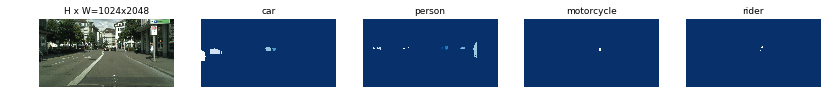

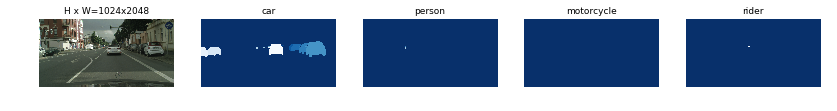

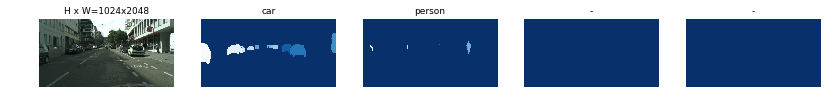

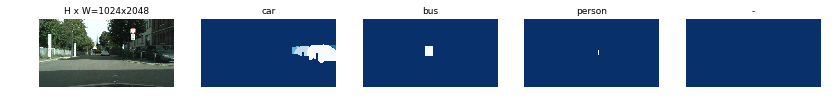

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)[:,:,:3]
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    #model.loadflow_weights(os.path.join(ROOT_DIR, "flow/flownet-s.h5"), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all"` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='all')

In [ ]:
# Fine tune flow
# Passing layers="finetune" trains flow layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30, 
            layers="finetune")

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=40, 
            layers="finetune")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(CityscapeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    FLOW= "flownets"

inference_config = InferenceConfig()
inference_config.IMAGE_SHAPE = [1024,1024,6]
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/susean/Mask_RCNN/logs/after50/mask_rcnn_cityscapes_0040.h5


original_image           shape: (1024, 1024, 6)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (6, 4)                min:  171.00000  max:  585.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  uint8


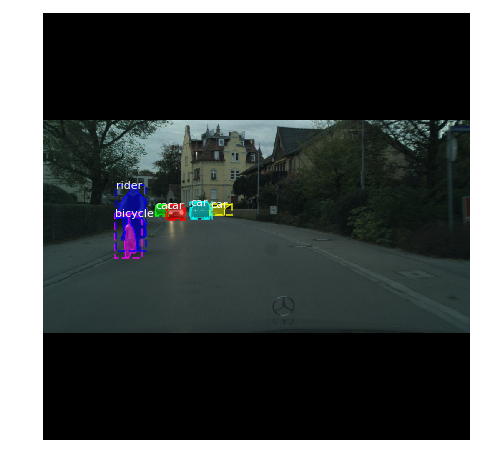

In [12]:
# Test on a random image
image_id = 3#random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image[:,:,:3], gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 6)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 6)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 21)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


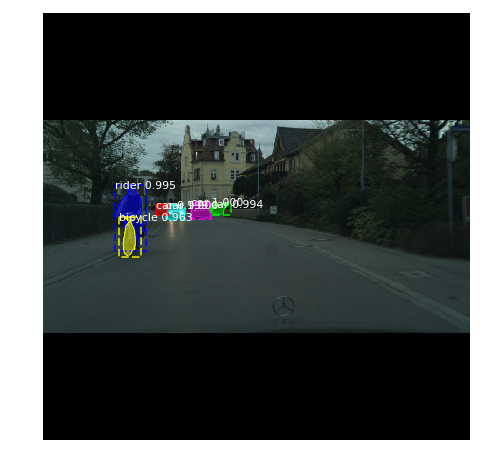

In [13]:
molded_images = np.expand_dims(original_image, 0)
image_metas = np.expand_dims(image_meta, 0)
results = model.detect_molded(molded_images, image_metas, verbose=1)

r = results[0]
visualize.display_instances(original_image[:,:,:3], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
#image_ids = np.random.choice(dataset_val.image_ids, 10)
AP50s = []
APs = []
for image_id in range(len(dataset_val.image_ids)):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(image, 0)
    image_metas = np.expand_dims(image_meta, 0)

    # Run object detection
    results = model.detect_molded(molded_images, image_metas, verbose=0)
    r = results[0]

    if np.sum(r["scores"]) == 0:
        print("{} Fasle".format(image_id))
        continue
        
    # Compute AP
    AP, precisions, recalls, overlaps =utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    AP50s.append(AP)
    AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], verbose=0)
    APs.append(AP)
    if image_id % 100 == 0:
        print("step: {:3d}, AP50: {:.3f}, mAP: {:.3f}".format(image_id, np.mean(AP50s), np.mean(APs)))
        
print("step: {:3d}, AP50: {:.3f}, mAP: {:.3f}".format(image_id, np.mean(AP50s), np.mean(APs)))